## Code start!!
Target is ResalePrices via RandomForestRegressor

Base (first) version of this, without adding more geographic features and separated (month only) temporal pattern

added Flat_age, a column for how old a flat is based on the data of the remaining lease compared to when the data was taken

In [ ]:
import pandas as pd
df = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
df.head()

NameError: name 'df' is not defined

In [5]:
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [6]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np  
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

df['flat_age'] = df['month'].str[:4].astype(int) - df['lease_commence_date']
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,flat_age
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,38
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,39
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,37
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,37
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...
205598,2025-01,YISHUN,EXECUTIVE,836,YISHUN ST 81,01 TO 03,146.0,Maisonette,1988,62 years 02 months,960000.0,37
205599,2025-02,YISHUN,EXECUTIVE,824,YISHUN ST 81,01 TO 03,145.0,Apartment,1987,61 years 10 months,868888.0,38
205600,2025-02,YISHUN,EXECUTIVE,826,YISHUN ST 81,10 TO 12,146.0,Maisonette,1988,62 years,1100888.0,37
205601,2025-04,YISHUN,EXECUTIVE,877,YISHUN ST 81,07 TO 09,142.0,Apartment,1987,61 years 09 months,988000.0,38


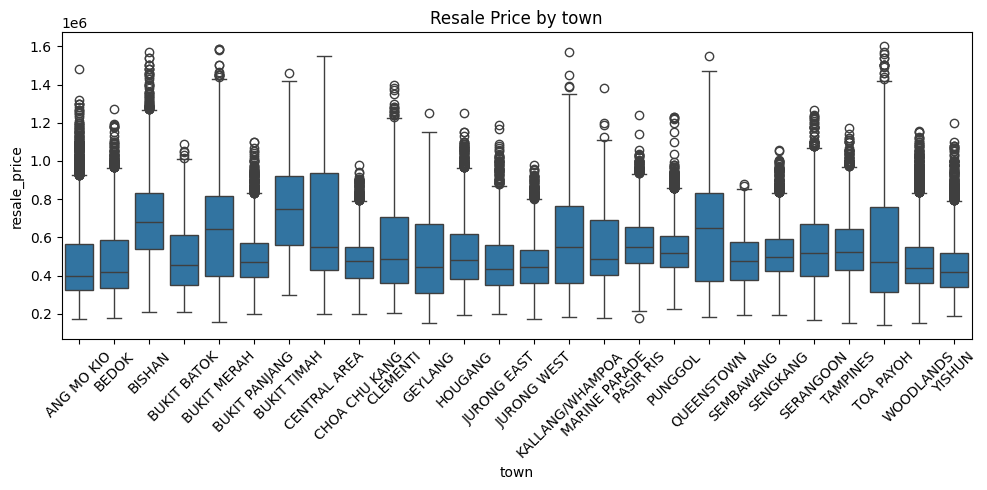

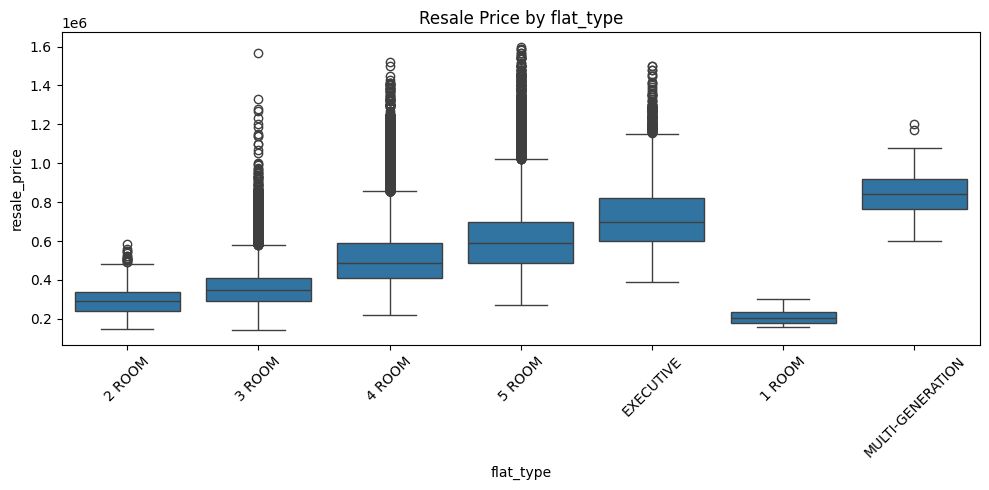

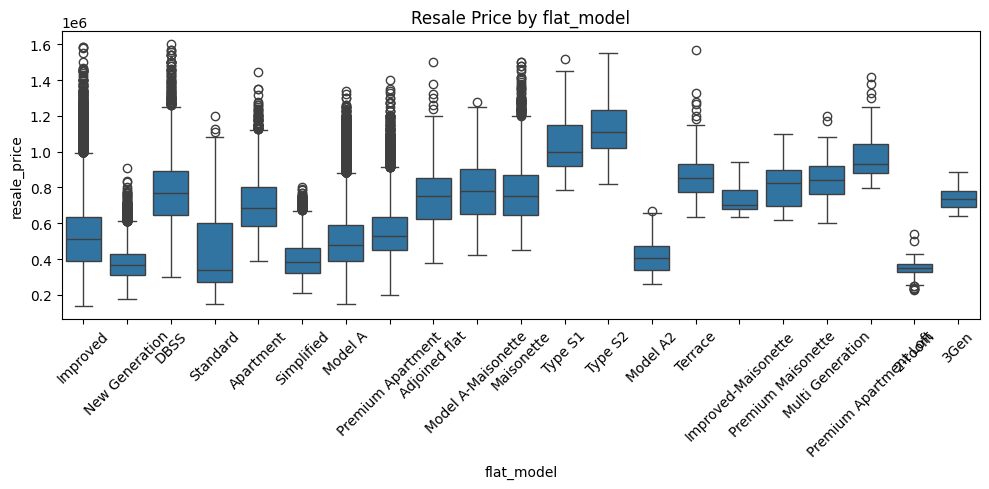

In [7]:
categorical_features = ['town', 'flat_type', 'flat_model']
numerical_features = ['floor_area_sqm', 'flat_age']


for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='resale_price', data=df)
    plt.title(f'Resale Price by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [8]:
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['resale_price', 'floor_area_sqm', 'flat_age']:
    df = remove_outliers_iqr(df, col)

In [9]:
cat = ['town', 'flat_type', 'flat_model']
num = ['floor_area_sqm', 'flat_age']
x = df[['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'flat_age']]
y = df['resale_price']

pre = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
        ('num', StandardScaler(), num)
    ]
)


In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', pre),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline.fit(x_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['town', 'flat_type',
                                                   'flat_model']),
                                                 ('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'flat_age'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [11]:
y_pred = pipeline.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")


Root Mean Squared Error: 56822.32


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.3f}")

R^2 Score: 0.880
